This notebooks works with a set of elemental libs line data downloaded from the nist libs website.
The lines produced for a compound like Li2CO3 is the weighted sum of these elemental lines.
The process to make simulated libs spectra with spec_maker will leverage this fact.
Note that doppler-spread spectra don't add linearly in the same way as lines. So though we can create
the weighted elemental spectra as well, they won't "add" to the composite from a total intensity view.

In [1]:
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
import pickle

top_dir = Path.cwd().parent 
datapath = top_dir / 'data' / 'nist_libs'


In [3]:
#import data
el_symb = np.genfromtxt(datapath / 'elem_symb.csv', dtype=str)

In [3]:
#example read
#Ti_lines = np.genfromtxt(datapath / 'elem_libs' / 'Ti.csv', delimiter=",",skip_header=1, filling_values='0')
#line_wl = np.round(Ti_lines[:,0]).astype('int')
#line_int = np.sum(Ti_lines[:,1:], axis=1)

In [4]:
#Process the elemental lines data into a common format compatible with our libs gun
#On the interval 180 - 961 nm aggregate intensity across all the ionizations
# wave and atomic_lines dict will be stored as pickle for use in other modules
wl_low = 180
wl_high = 961
inc = 1
wave = np.arange(wl_low, wl_high+1, inc)
atomic_lines = {k:np.zeros(len(wave)) for k in el_symb}

#traverse the atomic lines dict by element.
#Open Nist data file, round wl to one in our domain and sum intensities across ions for the row
#Update the dict entry by adding the intensity. Note multiple lines may round to same integer wl
for el in atomic_lines.keys():
    filepath = datapath / 'elem_libs' / f'{el}.csv'
    el_lines = np.genfromtxt(filepath, delimiter=",",skip_header=1, filling_values='0')
    line_wl = np.round(el_lines[:,0]).astype('int')
    line_int = np.sum(el_lines[:,1:], axis=1)
    for i in range(len(line_wl)):
        if line_wl[i] >= wl_low and line_wl[i] <= wl_high:
            #note line_wl - wl_low puts us into array index space
            atomic_lines[el][line_wl[i] - wl_low] += line_int[i]

<function matplotlib.pyplot.show(close=None, block=None)>

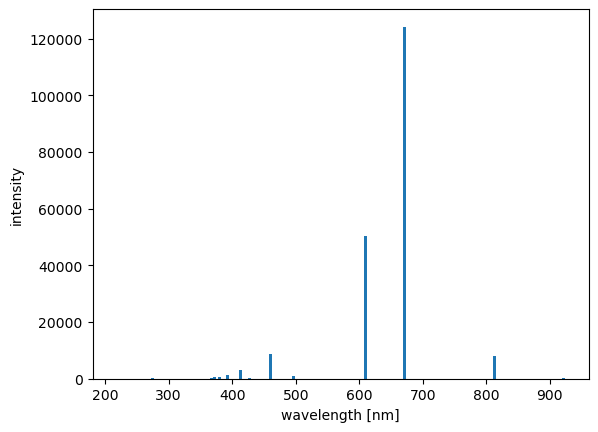

In [5]:
#Review lines plot
el = 'Li'
plt.bar(x=wave, height = atomic_lines[el], width=5) #note width impacts line vis
plt.xlabel('wavelength [nm]')
plt.ylabel('intensity')
plt.xlim([wl_low, wl_high]) #note data may go beyond this range
plt.show


In [24]:
#Persist data for use in spectrum generation and other libraries
#with open(datapath / 'nist_elem_libs.pickle', 'wb') as f:
#    pickle.dump(wave, f)
#    pickle.dump(atomic_lines, f)

#import pickle
#with open(datapath / 'nist_elem_libs.pickle', 'rb') as f:
#    wave = pickle.load(f)
#    atomic_lines = pickle.load(f)

In [9]:
#Another approach for higher resolution data gen, equivalent to SciAps gun at 0.0333 nm sampling
#Process the elemental lines data into a common format compatible with our libs gun
#On the interval 180 - 961 nm aggregate intensity across all the ionizations
# wave and atomic_lines dict will be stored as pickle for use in other modules
wl_low = 180 #from sciapps data file
wl_high = 961 #from sciapps data file
inc = 0.03333333333333 #from sciapps data file
#we could generate a range spanning 0:1 and add to range of ints to avoid slight drift error, but not needed here
wave = np.arange(wl_low, wl_high, inc)
atomic_lines = {k:np.zeros(len(wave)) for k in el_symb}

#traverse the atomic lines dict by element.
#Open Nist data file, transform wl to one in our domain and sum intensities across ions for the row
#Update the dict entry by adding the intensity. Note multiple lines may round to same wl
for el in atomic_lines.keys():
    filepath = datapath / 'elem_libs' / f'{el}.csv'
    el_lines = np.genfromtxt(filepath, delimiter=",",skip_header=1, filling_values='0')
    #need to consider our starting point and increment and put exactly on that same domain
    line_wl = el_lines[:,0] #raw wl will need to be put on our grid
    line_int = np.sum(el_lines[:,1:], axis=1) #all the ion intensity at this wl point
    total_int = np.sum(el_lines[:,1:], axis=None) #obtain a total intensity to compare against as check
    for i in range(len(line_wl)):
        if line_wl[i] >= wl_low and line_wl[i] <= wl_high:
            #figure the closest index in wave for this nist wl
            wave_ind = np.round((line_wl[i] - wl_low) / inc, 0).astype('int')
            atomic_lines[el][wave_ind] += line_int[i]
    if np.abs(total_int - np.sum(atomic_lines[el])) > 0.1:
        print(f"{el}: calc error, data loss")

<function matplotlib.pyplot.show(close=None, block=None)>

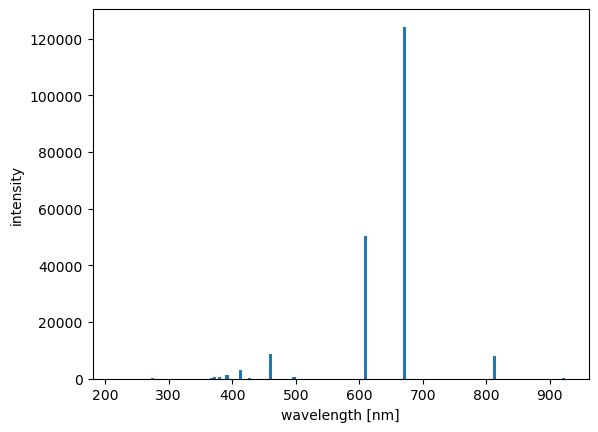

In [7]:
#Review lines plot 
el = 'Li'
plt.bar(x=wave, height = atomic_lines[el], width=5) #note width impacts line vis
plt.xlabel('wavelength [nm]')
plt.ylabel('intensity')
plt.xlim([wl_low, wl_high]) #note data may go beyond this range
plt.show

In [11]:
len(wave)

23431

In [12]:
#Persist data for use in spectrum generation and other libraries
with open(datapath / 'nist_libs_hi_res.pickle', 'wb') as f:
    pickle.dump(wave, f)
    pickle.dump(atomic_lines, f)

#import pickle
#with open(datapath / 'nist_libs_hi_res.pickle', 'rb') as f:
#    wave = pickle.load(f)
#    atomic_lines = pickle.load(f)